In [3]:
!pip install -q -U keras-tuner

# Import Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt 
import random

# -----------------------------------
import tensorflow as tf
import keras
from tensorflow import keras
import keras_tuner as kt

# Preprocessing images and Train/Test split

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [6]:
train_images  = train_images / 255.0
test_images = test_images / 255.0

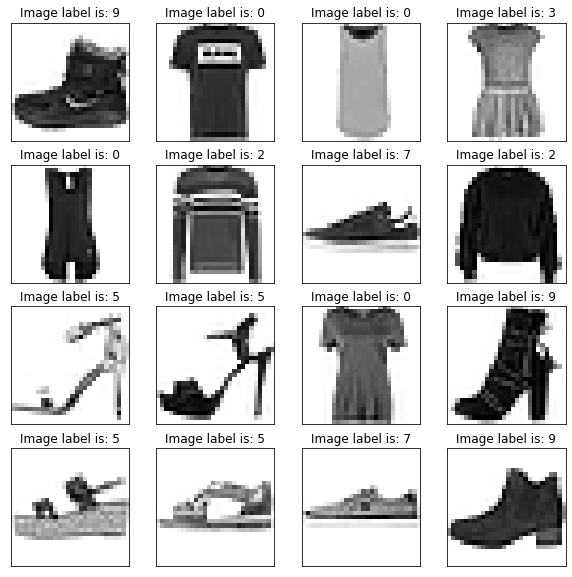

In [7]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.title("Image label is: {}".format(train_labels[i]))
plt.show()


In [8]:
x_train = train_images.reshape(-1,28,28,1)
x_test = test_images.reshape(-1,28,28,1)

# Hyperparameter tuning (with keras_tuner) and Build Model

In [9]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [10]:
def build_model(hp):
    model = keras.Sequential([
        
    # First conv_block
    keras.layers.Conv2D(
        filters = hp.Choice('conv_1_filter', values=[16, 32, 64, 128]),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,4]),
        activation='relu',
        input_shape=(28,28,1)),
    keras.layers.MaxPooling2D((2,2)),
    
    # Second conv_block
    keras.layers.Conv2D(
        filters = hp.Choice('conv_2_filter', values=[16, 32, 64, 128]),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,4]),
        activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    
    # --------------------------------
    keras.layers.Flatten(),
    keras.layers.Dense(units = hp.Choice('units', values=[16, 32, 64, 128, 256]),
                       activation='relu'),
    keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)),
        
    # --------------------------------
    keras.layers.Dense(10)
    ])

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', 
                                                            values=[1e-1, 1e-2, 1e-3, 1e-4])),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

In [11]:
tuner = kt.Hyperband(build_model,
                     objective="val_accuracy",
                     max_epochs=5,
                     factor=3,
                     hyperband_iterations=3)

2022-12-17 12:30:06.162661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 12:30:06.270453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 12:30:06.271257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 12:30:06.272458: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
conv_1_filter (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 4], 'ordered': True}
conv_2_filter (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 4], 'ordered': True}
units (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256], 'ordered': True}
dropout (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [13]:
tuner.search(x_train,train_labels, epochs=3, validation_split=0.2)

Trial 30 Complete [00h 00m 42s]
val_accuracy: 0.8424999713897705

Best val_accuracy So Far: 0.9085000157356262
Total elapsed time: 00h 10m 49s


In [14]:
best_hps = best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""conv_1_filter is {best_hps.get('conv_1_filter')}""")
print(f"""conv_1_kernel is {best_hps.get('conv_1_kernel')}""")
print(f"""conv_2_filter is {best_hps.get('conv_2_filter')}""")
print(f"""conv_2_kernel is {best_hps.get('conv_2_kernel')}""")
print("-------------------------------------------------")
print(f"""units is {best_hps.get('units')}""")
print(f"""learning_rate is {best_hps.get('learning_rate')}""")
print(f"""dropout is {best_hps.get('dropout')}""")

conv_1_filter is 128
conv_1_kernel is 3
conv_2_filter is 128
conv_2_kernel is 3
-------------------------------------------------
units is 32
learning_rate is 0.001
dropout is 0.0


In [15]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, train_labels, 
                    epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4710 - accuracy: 0.8275 - val_loss: 0.3543 - val_accuracy: 0.8738
Epoch 2/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3155 - accuracy: 0.8845 - val_loss: 0.3205 - val_accuracy: 0.8821
Epoch 3/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2661 - accuracy: 0.9022 - val_loss: 0.2807 - val_accuracy: 0.8985
Epoch 4/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2333 - accuracy: 0.9141 - val_loss: 0.2658 - val_accuracy: 0.9018
Epoch 5/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2067 - accuracy: 0.9241 - val_loss: 0.2485 - val_accuracy: 0.9093
Epoch 6/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1821 - accuracy: 0.9324 - val_loss: 0.2490 - val_accuracy: 0.9097
Epoch 7/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1621 - accuracy: 0.9410 - val_loss: 0.2460 - val_accuracy:

In [16]:
hypermodel = tuner.hypermodel.build(best_hps)

history = hypermodel.fit(x_train, train_labels, 
                         epochs=best_epoch, 
                         validation_split=0.2, 
                         callbacks=[early_stop])

Epoch 1/7
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4695 - accuracy: 0.8297 - val_loss: 0.4247 - val_accuracy: 0.8506
Epoch 2/7
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3119 - accuracy: 0.8866 - val_loss: 0.2926 - val_accuracy: 0.8957
Epoch 3/7
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2658 - accuracy: 0.9035 - val_loss: 0.2722 - val_accuracy: 0.9001
Epoch 4/7
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2352 - accuracy: 0.9140 - val_loss: 0.3125 - val_accuracy: 0.8882
Epoch 5/7
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2083 - accuracy: 0.9233 - val_loss: 0.2451 - val_accuracy: 0.9129
Epoch 6/7
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1849 - accuracy: 0.9327 - val_loss: 0.2497 - val_accuracy: 0.9123
Epoch 7/7
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1654 - accuracy: 0.9390 - val_loss: 0.2618 - val_accuracy: 0.9065

In [17]:
hypermodel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 128)       1280      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                102432    
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)               

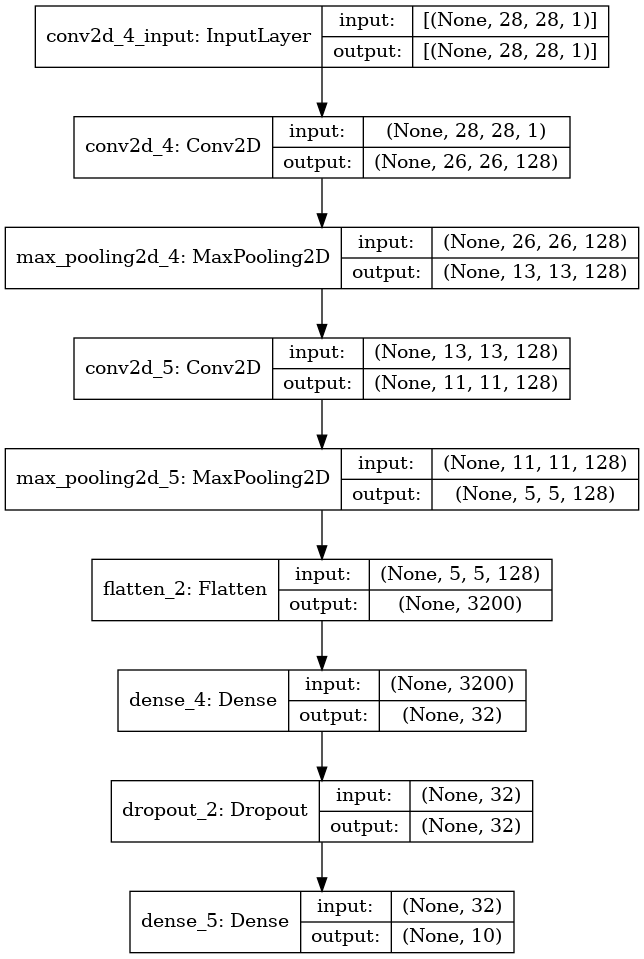

In [18]:
keras.utils.plot_model(hypermodel, show_shapes=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


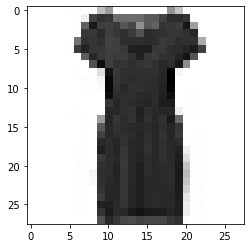

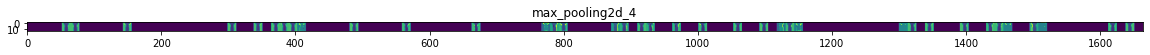

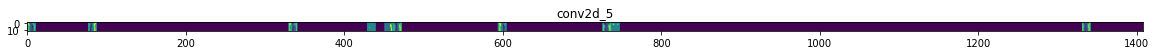

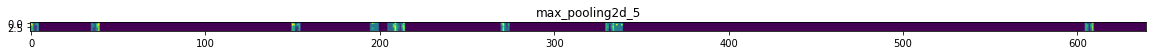

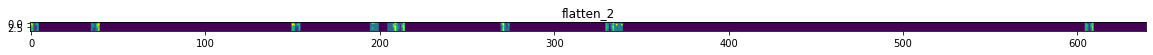

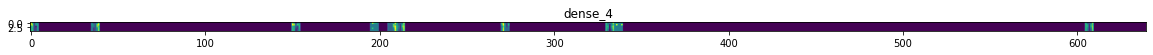

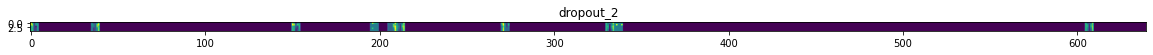

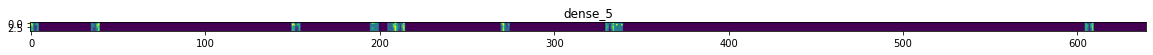

In [19]:
successive_outputs = [layer.output for layer in hypermodel.layers[1:]]
visualization_model = keras.models.Model(inputs = hypermodel.input, outputs = successive_outputs)
index = 20
plt.imshow(train_images[index], cmap=plt.cm.binary)

x = train_images[index]
x = x.reshape((1,) + x.shape)
x /= 255
successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in hypermodel.layers[1:]]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1] 
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x

    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Evaluation and Prediction

In [20]:
eval_result = hypermodel.evaluate(x_test, test_labels)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 3ms/step - loss: 0.2828 - accuracy: 0.8958
[test loss, test accuracy]: [0.2827785909175873, 0.895799994468689]


In [21]:
pred = hypermodel.predict(x_test)

print("Prediction is -> {}".format(pred[12]))
print("Actual value is -> {}".format(test_labels[12]))
print("The highest value for label is {}".format(np.argmax(pred[12])))

Prediction is -> [ -5.9582376  -8.575347   -8.3154745  -6.5234003 -10.199494    2.454381
 -13.637774    2.5910397  -2.2836535  -1.4214184]
Actual value is -> 7
The highest value for label is 7


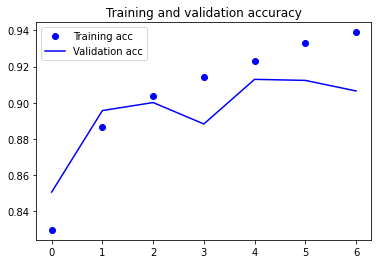

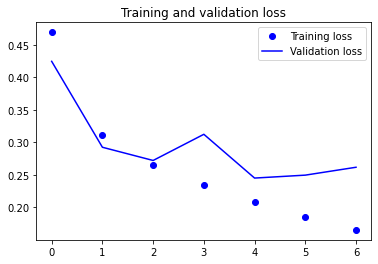

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss'] 

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()